# Статистический анализ данных

**Мы аналитики популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.**

**План работы.**
1. Изучить общую информацию о каждом датафрейме.
2. Проверить наличие пропущенных значений и дубликатов в датафреймах. Обработать их, если такие значения присутствуют.
3. Описать и визуализировать общую информацию о пользователях и поездках:
  1. частота встречаемости городов;
  2. соотношение пользователей с подпиской и без подписки;
  3. возраст пользователей;
  4. расстояние, которое пользователь преодолел за одну поездку;
  5. продолжительность поездок.
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.info()
users.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


**Пропусков нет, поля заполнены, типы в порядке, идем дальше.**

In [4]:
print(rides.head(10))
rides.info()

   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28
5        1  2770.890808  16.650138  2021-10-09
6        1  3039.020292  14.927879  2021-10-19
7        1  2842.118050  23.117468  2021-11-06
8        1  3412.690668  15.238072  2021-11-14
9        1   748.690645  15.041884  2021-11-22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Пропусков тоже нет. Поле `date` имеет тип object, поменяем на тип datetime на шаге предобработки данных.**

In [5]:
print(subscriptions)

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199


**Тут все хорошо.**

#### Шаг 2. Предобработка данных

**Поменяем типы данных в столбце `date`, проверим датасеты на наличие дубликатов.**

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Считаем дубликаты.**

In [7]:
print(rides.duplicated().sum())
print(users.duplicated().sum())

0
31


In [8]:
df_duplicated = users[users.duplicated()].sort_values(by='user_id', ascending=True)
print(users[users['name'] == 'Амалия'])

      user_id    name  age          city subscription_type
15         16  Амалия   27     Краснодар             ultra
439       440  Амалия   20        Тюмень             ultra
787       788  Амалия   34     Пятигорск              free
976       977  Амалия   22        Москва              free
1248     1249  Амалия   28        Тюмень              free
1262     1263  Амалия   27  Екатеринбург              free
1324     1325  Амалия   36          Сочи              free
1535       16  Амалия   27     Краснодар             ultra


In [9]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

**Типы поменял, дубликаты выявил и почистил, двигаемся дальше.**

#### Шаг 3. Исследовательский анализ данных

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

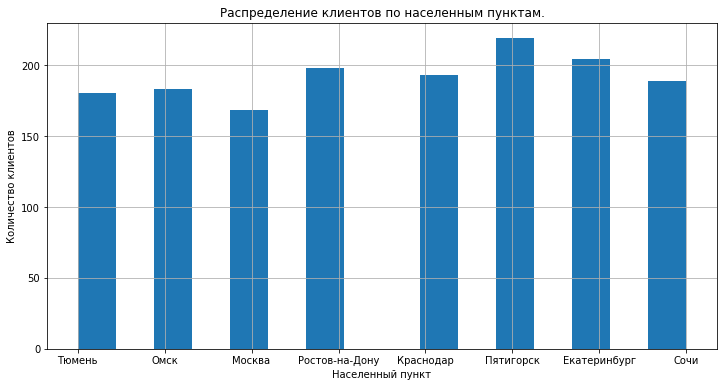

In [10]:
users['city'].hist(bins=16, figsize=(12, 6))
plt.xlabel('Населенный пункт')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по населенным пунктам.')
users['city'].value_counts()

**В предложенной выборке прокат самокатов представлен в 8 городах и эти города распределены примерно одинаково. от 168 в Москве, до 219 в Пятигорске.**

<AxesSubplot:ylabel='subscription_type'>

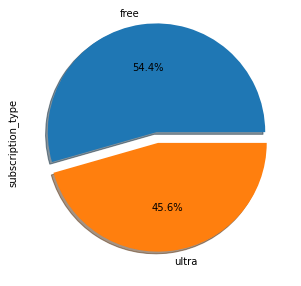

In [11]:
users['subscription_type'].value_counts().plot(kind='pie', figsize=(5, 5), autopct = '%1.1f%%', explode = (0.1, 0), shadow=True)

**Соотношение пользователей с подпиской и без примерно 45% на 55% соответственно.**

Среднее значение: 24.9 , Медиана: 25.0


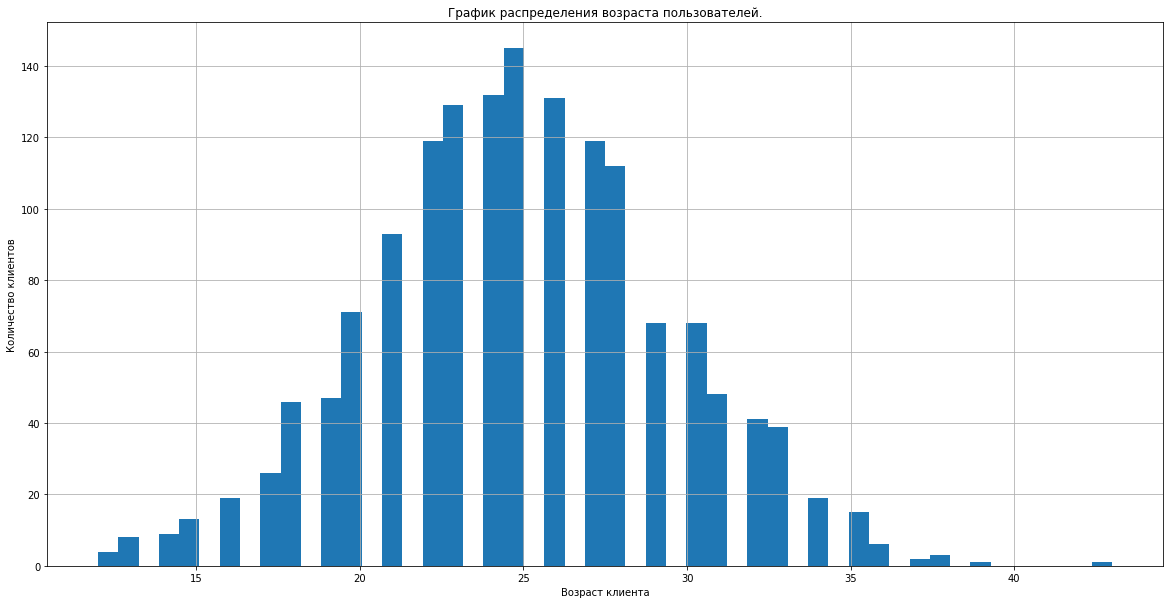

In [12]:
users['age'].hist(bins=50, figsize=(20, 10), grid=True)
plt.xlabel('Возраст клиента')
plt.ylabel('Количество клиентов')
plt.title('График распределения возраста пользователей.')
print('Среднее значение:', round(users['age'].mean(), 1), ',', 'Медиана:', users['age'].median())

Среднее значение: 3070.7 , Медиана: 3133.6


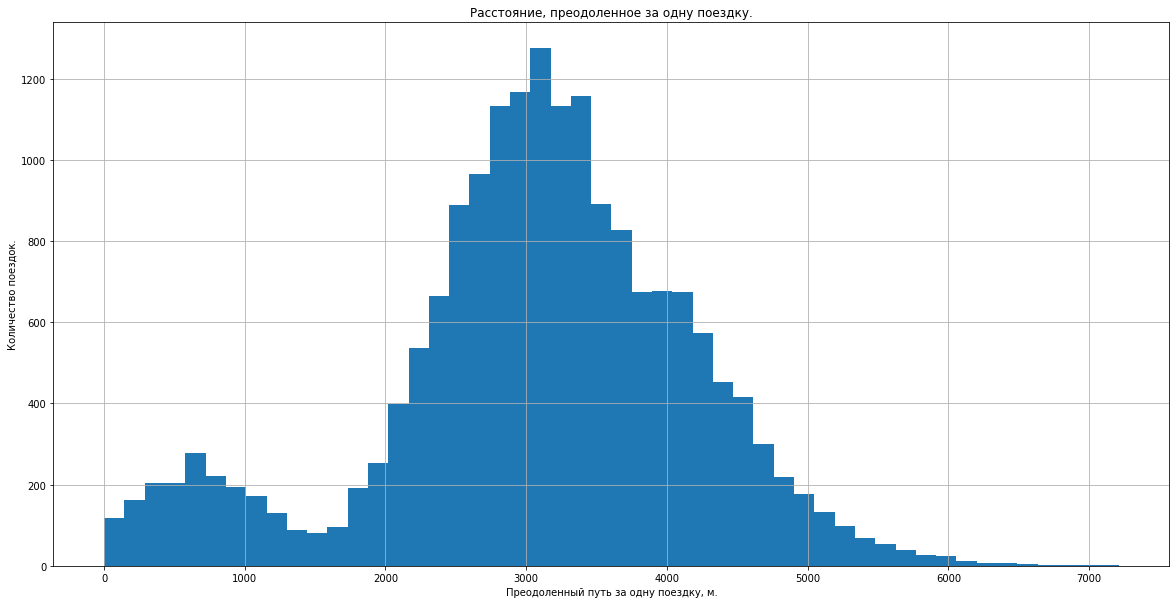

In [13]:
rides['distance'].hist(bins=50, figsize=(20, 10), grid=True)
plt.xlabel('Преодоленный путь за одну поездку, м.')
plt.ylabel('Количество поездок.')
plt.title('Расстояние, преодоленное за одну поездку.')
print('Среднее значение:', round(rides['distance'].mean(), 1), ',', 'Медиана:', round(rides['distance'].median(), 1))

**В среднем за поездку пользователь проезжает около 3 км. Встречаются поездки протяженностью более 6 км, а есть около 100 поездок, протяженностью близкой к нулю. Надеюсь, это не связано с разрядкой батареи или неисправностью самоката. Я бы расстроился =)**

Среднее значение: 17.8 , Медиана: 17.7


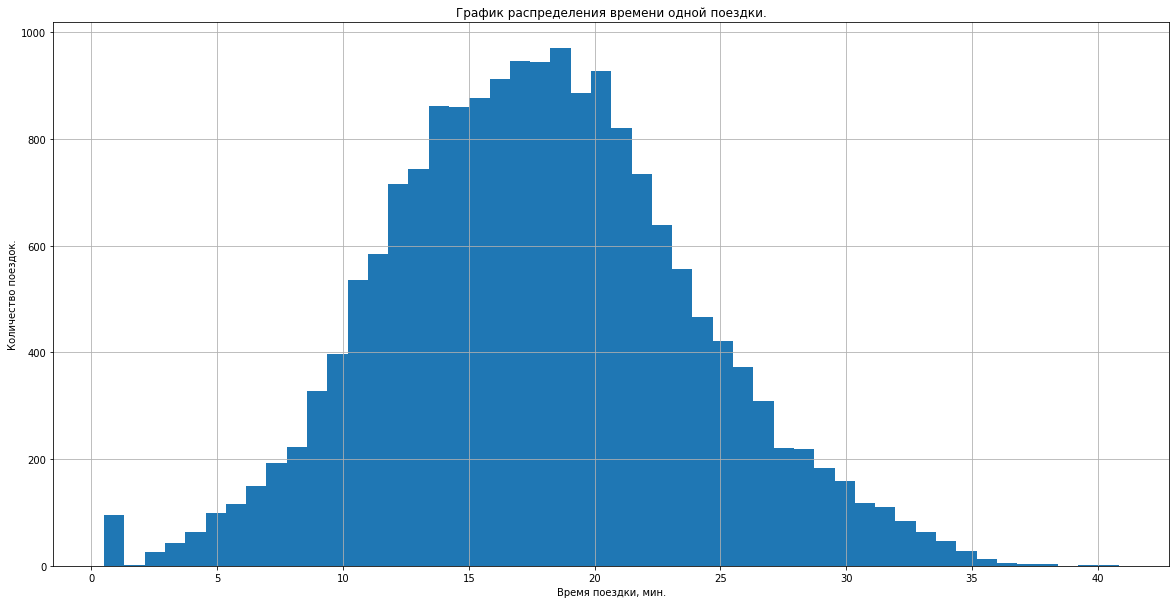

In [14]:
rides['duration'].hist(bins=50, figsize=(20, 10), grid=True)
plt.xlabel('Время поездки, мин.')
plt.ylabel('Количество поездок.')
plt.title('График распределения времени одной поездки.')
print('Среднее значение:', round(rides['duration'].mean(), 1), ',', 'Медиана:', round(rides['duration'].median(), 1))

In [15]:
rides[rides['duration'] < 1]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


**В среднем поездки продолжаются около 17 минут. Есть более продолжительные, для более дальних поездок и наоборот. Все логично. Выявлено 95 аномальных поездок: 6 км за 30 сек. Скажите, где купить такой самокат?**

#### Шаг 4. Объединение данных

In [16]:
users_merge = users.merge(rides, on='user_id', how='left')
total_merge = users_merge.merge(subscriptions, on='subscription_type', how='left')
total_merge['duration'] = np.ceil(total_merge['duration']).astype('int')
total_merge.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,17,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,15,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,24,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,16,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,16,2021-11-22,11,6,0,199


In [17]:
users_free = total_merge[total_merge['subscription_type'] == 'free']
users_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  int64         
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.1+ MB


In [18]:
users_ultra = total_merge[total_merge['subscription_type'] == 'ultra']
users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   int64         
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 660.2+ KB


Среднее расстояние у пользователей без подписки: 3045.5 , Медиана: 3114.6
Среднее расстояние у пользователей с подпиской: 3115.4 , Медиана: 3148.6


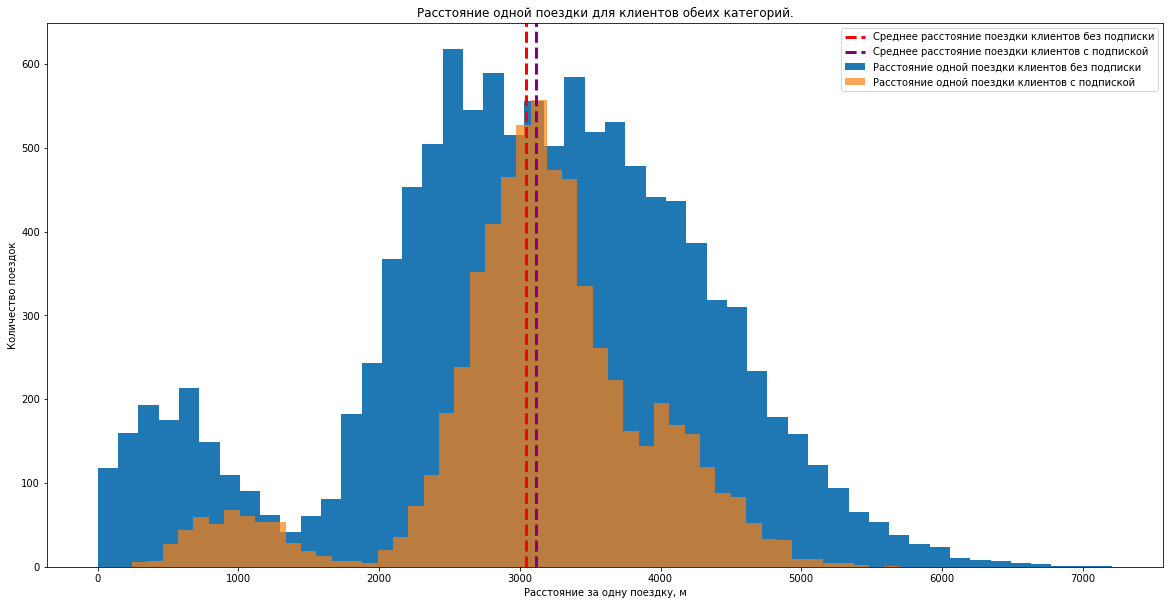

In [19]:
print('Среднее расстояние у пользователей без подписки:', round(users_free['distance'].mean(), 1), ',', 'Медиана:', round(users_free['distance'].median(), 1))
print('Среднее расстояние у пользователей с подпиской:', round(users_ultra['distance'].mean(), 1), ',', 'Медиана:', round(users_ultra['distance'].median(), 1))
plt.figure(figsize=(20, 10))
plt.hist(users_free['distance'], 50, label='Расстояние одной поездки клиентов без подписки')
plt.hist(users_ultra['distance'], 50, label='Расстояние одной поездки клиентов с подпиской', alpha=0.7)
plt.axvline (x=np.nanmean(users_free['distance']), color='red', linestyle='--', linewidth=3 , label='Среднее расстояние поездки клиентов без подписки')
plt.axvline (x=np.nanmean(users_ultra['distance']), color='purple', linestyle='--', linewidth=3 , label='Среднее расстояние поездки клиентов с подпиской')
plt.xlabel('Расстояние за одну поездку, м')
plt.ylabel('Количество поездок')
plt.title('Расстояние одной поездки для клиентов обеих категорий.')
plt.legend()

**В среднем пользователи обеих категорий проезжают около 3 км в течение одной поездки. Пользователи без подписки пользуются самокатами почти в 2 раза чаще**

Среднее время поездки пользователей без подписки: 17.9 , Медиана: 18.0
Среднее время поездки пользователей с подпиской: 19.0 , Медиана: 19.0


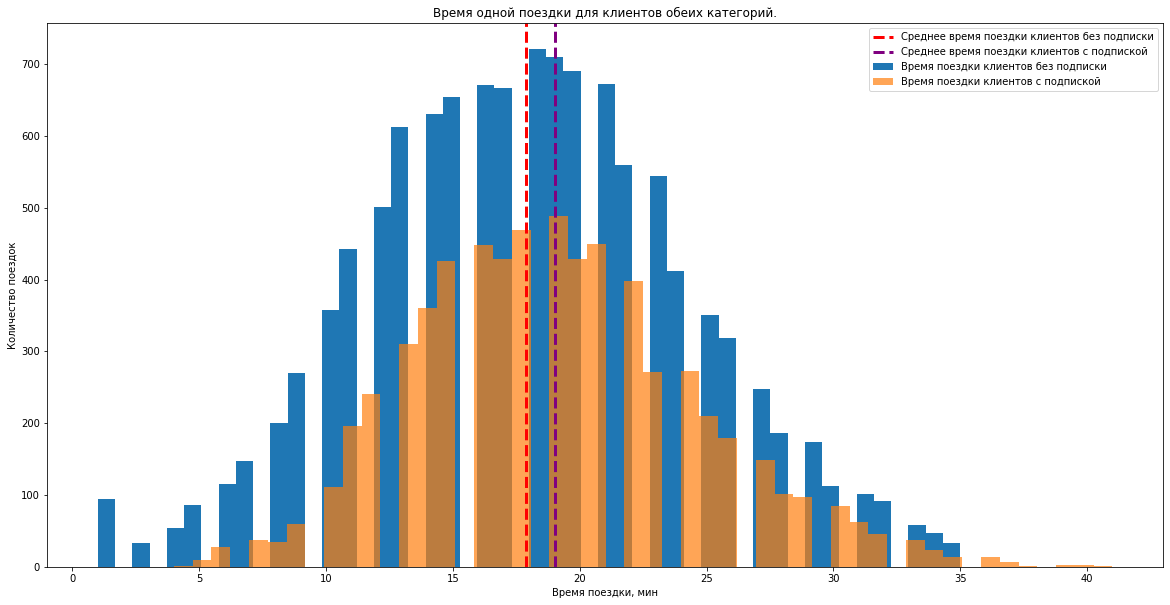

In [20]:
print('Среднее время поездки пользователей без подписки:', 
      round(users_free['duration'].mean(), 1), ',', 'Медиана:', round(users_free['duration'].median(), 1))
print('Среднее время поездки пользователей с подпиской:', 
      round(users_ultra['duration'].mean(), 1), ',', 'Медиана:', round(users_ultra['duration'].median(), 1))
plt.figure(figsize=(20, 10))
plt.hist(users_free['duration'], 50, label='Время поездки клиентов без подписки')
plt.hist(users_ultra['duration'], 50, label='Время поездки клиентов с подпиской', alpha=0.7)
plt.axvline (x=np.nanmean(users_free['duration']), color='red', linestyle='--', linewidth=3 , label='Среднее время поездки клиентов без подписки')
plt.axvline (x=np.nanmean(users_ultra['duration']), color='purple', linestyle='--', linewidth=3 , label='Среднее время поездки клиентов с подпиской')
plt.xlabel('Время поездки, мин')
plt.ylabel('Количество поездок')
plt.title('Время одной поездки для клиентов обеих категорий.')
plt.legend()

**Время поездки у пользователей примерно одинаковый.**

#### Шаг 5. Подсчёт выручки

In [21]:
free = (
    users_free
    .pivot_table(
    index = ['user_id', 'month'], 
    values = ['distance', 'name', 
              'duration', 'subscription_type', 
              'minute_price', 'start_ride_price', 'subscription_fee'], 
    aggfunc = {'distance':'sum', 
               'name':'count', 
               'duration':'sum', 
               'subscription_type': 'max', 
               'minute_price':'mean', 
               'start_ride_price':'mean', 
               'subscription_fee':'mean'})
    .reset_index()
    .rename(columns={'name':'count_ride', 'duration':'total_duration', 'distance': 'total_distance'})
)
free['total_price'] = (free['start_ride_price'] * free['count_ride']) + (free['minute_price'] * free['total_duration'] \
                                                                         + free['subscription_fee'])
free.head()

,user_id,month,total_distance,total_duration,minute_price,count_ride,start_ride_price,subscription_fee,subscription_type,total_price
0,700,1,2515.690719,15,8,1,50,0,free,170
1,700,2,13446.659764,89,8,5,50,0,free,962
2,700,3,3798.334905,19,8,1,50,0,free,202
3,700,4,2984.551206,16,8,1,50,0,free,178
4,700,6,5927.650988,29,8,2,50,0,free,332


Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки 
× общая продолжительность всех поездок в минутах + стоимость подписки.

In [22]:
ultra = (
    users_ultra
    .pivot_table(
    index = ['user_id', 'month'], 
    values = ['distance', 'name', 'duration', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'], 
    aggfunc = {'distance':'sum', 
               'name':'count', 
               'duration':'sum', 
               'subscription_type': 'max', 
               'minute_price':'mean', 
               'start_ride_price':'mean', 
               'subscription_fee':'mean'})
    .reset_index()
    .rename(columns={'name':'count_ride', 'duration':'total_duration', 'distance': 'total_distance'})
)
ultra['total_price'] = (ultra['start_ride_price'] * ultra['count_ride']) + (ultra['minute_price'] * ultra['total_duration'] \
                                                                             + ultra['subscription_fee'])
ultra.head()

,user_id,month,total_distance,total_duration,minute_price,count_ride,start_ride_price,subscription_fee,subscription_type,total_price
0,1,1,7027.511294,42,6,2,0,199,ultra,451
1,1,4,754.159807,7,6,1,0,199,ultra,241
2,1,8,6723.470560,46,6,2,0,199,ultra,475
3,1,10,5809.911100,32,6,2,0,199,ultra,391
4,1,11,7003.499363,56,6,3,0,199,ultra,535


**Посчитаем как изменится месячная выручка пользователей без подписки, если бы у них была подписка.**

In [23]:
free_ul = free
free_ul['total_price_ultra'] = (0 * free['count_ride']) + (6 * free['total_duration']) + 199                                    
print('Возможная средняя месячная выручка:', round(free_ul['total_price'].mean(), 2))
free_ul.head()

Возможная средняя месячная выручка: 328.64


,user_id,month,total_distance,total_duration,minute_price,count_ride,start_ride_price,subscription_fee,subscription_type,total_price,total_price_ultra
0,700,1,2515.690719,15,8,1,50,0,free,170,289
1,700,2,13446.659764,89,8,5,50,0,free,962,733
2,700,3,3798.334905,19,8,1,50,0,free,202,313
3,700,4,2984.551206,16,8,1,50,0,free,178,295
4,700,6,5927.650988,29,8,2,50,0,free,332,373


**Видно, что встречаются пользователи, активно пользующиеся самокатами. Если таким оформить подписку, то выручка может снизиться. Нужно найти таких пользователей, которым было бы выгодно овормить подписку (естественно, с точки зрения компании).**

In [24]:
def promo_users(total_duration, count_ride):
    if total_duration * 2 + count_ride * 50 < 199:
        return 'promo_user'
    else:
        return 'not_promo'
free_ul['promo_user'] = free_ul.apply(lambda x: promo_users(x['total_duration'], x['count_ride']), axis=1)
free_ul['promo_user'].value_counts()

promo_user    5553
not_promo     1245
Name: promo_user, dtype: int64

**Провели небольшое исследование и выявили пользователей, которым стоит отправить промокоды, поскольку такие люди мало ездят и продолжительность их поездок невелика, то перейдя в категорию ultra, выручка от них увеличится.**

#### Шаг 6. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Нулевая гипотеза: Пользователи с подпиской тратят времени на поездки, столько же сколько пользователи без подписки.**
**Альтернативная гипотеза: Пользователи с подпиской тратят времени на поездки больше, чем пользователи без подписки.**

In [25]:
alpha = 0.05
results = st.ttest_ind(users_ultra['duration'], users_free['duration'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нулевую гипотезу не отвергаем.')

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу.


**Нулевую гипотезу отвергаем. Оставляем альтернативную гипотезу, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.**

**Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, такое же как и у пользователей без подписки.
Альтернативная гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

In [26]:
interested_value = 3130
alpha = 0.05
results = st.ttest_1samp(users_ultra['distance'], interested_value, alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нулевую гипотезу не отвергаем.')

p-значение: 0.08046311521502146
Нулевую гипотезу не отвергаем.


**Эту гипотезу не удалось отвергнуть. Мы не можем с уверенностью сказать, что пользователи с подпиской проезжают за одну поездку менее 3130 метров.**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. Альтернативная гипотеза: Помесячная выручка от пользователей с подпиской по месяцам больше, чем выручка от пользователей без подписки.**

In [27]:
results = st.ttest_ind(ultra['total_price'], free['total_price'], equal_var=False, alternative='greater')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нулевую гипотезу не отвергаем.')
print('Средняя помесячная выручка пользователей без подписки:', round(free['total_price'].mean(),2))
print('Средняя помесячная выручка пользователей с подпиской:', round(ultra['total_price'].mean(),2))

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу.
Средняя помесячная выручка пользователей без подписки: 328.64
Средняя помесячная выручка пользователей с подпиской: 362.79


**Похоже на правду, что пользователи с подпиской приносят больше денег.**

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**В данном случае нам пригодится тест для проверки гипотез о равенстве среднего генеральной совокупности для зависимых (парных) выборок, поскольку генеральная совокупность осталась той же, и нам нужно проверить что стало со средним после обновления.**

#### Шаг 7. Распределения

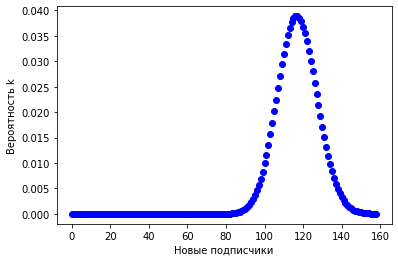

Вероятность не выполнить план при выданных 1170 промокодов: 0.049973377638439065


In [28]:
from matplotlib import pyplot as plt
from math import factorial
p = 0.1
n = 1170
lmbd = n * p
std_binom = (n * p * (1 - p))**0.5
max_value = int(n * p + 4 * std_binom)
binom_probs = []
poisson_probs = []
for k in range(max_value + 1):
    binom_prob = st.binom.pmf(k, n, p)
    binom_probs.append(binom_prob)
plt.plot(range(max_value + 1), binom_probs, 'bo')
plt.xlabel('Новые подписчики')
plt.ylabel('Вероятность k')
plt.show() 

threshold = 100
print(f'Вероятность не выполнить план при выданных {n} промокодов:', st.poisson.cdf(threshold - 1, lmbd))

**Нужно разослать не менее 1170 промокодов, чтобы чтобы вероятность не выполнить план была примерно 5%**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [29]:
p = 0.4
n = 1000000
lmbd = n * p
std_binom = (n * p * (1 - p))**0.5
distr = st.norm(lmbd, std_binom)
result = distr.cdf(399500)
print(result)

0.15371708296369768


**С вероятностью 15,37% уведомление откроет менее 399,5 тыс клиентов**

1. Были загружены предлагаемые датасеты, проведена первичная оценка данных:
 1. Посмотрели несколько строк для общего понимания;
 2. Просмотрена информация об этом датасете;
 3. Проведена предобработка данных:
2. Заменен тип данных в столбце `date` для удобной работы;
3. Объединены датасеты в один, затем получившаяся таблица разделили на данные по клиентам с подпиской и без нее.
4. На основании данных из получившихся таблиц были проанализированы время поездки и расстояние для каждой категории клиентов.
В соответствующие таблицы добавлены столбцы с информацией о суммарном времени поездок, дистанции и рассчитанной выручкой за месяц.
5. Проведено небольшое исследование и выявлены пользователи, которым стоит отправить промокоды (всего 5553 человека, довольно приличное количество), поскольку такие люди мало ездят и продолжительность их поездок невелика, то перейдя в категорию ultra, выручка от них увеличится. 
6. Проверены гипотезы от продакт-менеджеров:
 1. Нам удалось опровергнуть нулевую гипотезу, тест показал, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
 2. Не удалось опровергнуть гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Мы не можем утверждать это с уверенностью.
 3. Так же тест показал, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Нулевая гипотеза отвергается.